In [1]:
#Install Libraries
!pip install langchain_community
!pip install replicate
!pip install seaborn
!pip install sckit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.6/48.6 kB 2.1 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement sckit-learn (from versions: none)
ERROR: No matching distribution found for sckit-learn


In [26]:
#Import Libraries
from langchain_community.llms import Replicate
import os
from google.colab import userdata
import pandas as pd
import replicate
import json
import requests
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import time

#Set API Key
api_key = userdata.get('api_key')
os.environ['REPLICATE_API_TOKEN'] = api_key
print("API Key Setted")

API Key Setted


In [9]:
# Load Dataset "PRDECT-ID Dataset"
url_dataset = 'https://raw.githubusercontent.com/rhiosutoyo/PRDECT-ID-Indonesian-Product-Reviews-Dataset/main/Dataset/PRDECT-ID%20Dataset.csv'
response = requests.get(url_dataset)
content = response.text
df_prdect = pd.read_csv(url_dataset, sep=',')
df_prdect.rename(columns={'Customer Review': 'review'}, inplace=True)
df_prdect.rename(columns={'Emotion': 'emotion'}, inplace=True)
df_prdect.rename(columns={'Sentiment': 'sentiment'}, inplace=True)
print(df_prdect.head(5))
print(df_prdect.shape)
print("\nDistribusi Emosi:")
print(df_prdect['emotion'].value_counts())


                Category                                       Product Name  \
0  Computers and Laptops  Wireless Keyboard i8 Mini TouchPad Mouse 2.4G ...   
1  Computers and Laptops  PAKET LISENSI WINDOWS 10 PRO DAN OFFICE 2019 O...   
2  Computers and Laptops                SSD Midasforce 128 Gb - Tanpa Caddy   
3  Computers and Laptops  ADAPTOR CHARGER MONITOR LCD LED TV LG merek LG...   
4  Computers and Laptops  ADAPTOR CHARGER MONITOR LCD LED TV LG merek LG...   

                 Location   Price  Overall Rating  Number Sold  Total Review  \
0           Jakarta Utara   53500             4.9         5449          2369   
1  Kota Tangerang Selatan   72000             4.9         2359          1044   
2           Jakarta Barat  213000             5.0        12300          3573   
3           Jakarta Timur   55000             4.7         2030           672   
4           Jakarta Timur   55000             4.7         2030           672   

   Customer Rating                          

In [10]:
# Pool Data dan Data Split (Analysis dan Evaluasi)
teacher_samples = df_prdect.groupby('emotion').head(20).copy()
df_remaining = df_prdect.drop(teacher_samples.index)
df_pool, df_unused = train_test_split(
    df_remaining,
    train_size=300,
    random_state=42,
    stratify=df_remaining['emotion']
    )

analysis_samples, evaluation_samples = train_test_split(
    df_pool,
    test_size=0.20,
    random_state=42,
    stratify=df_pool['emotion']
    )
print(f"Jumlah Data Teacher: {len(teacher_samples)} (Data utama yang akan digunakan untuk latihan model)")
print(f"Jumlah Data Pool: {len(df_pool)}")
print(f"Jumlah Analysis Samples: {len(analysis_samples)} (Data utama yang akan dianalisis untuk insight bisnis)")
print(f"Jumlah Evaluation Samples: {len(evaluation_samples)} (Data 'uji' untuk mengukur akurasi model)")

Jumlah Data Teacher: 100 (Data utama yang akan digunakan untuk latihan model)
Jumlah Data Pool: 300
Jumlah Analysis Samples: 240 (Data utama yang akan dianalisis untuk insight bisnis)
Jumlah Evaluation Samples: 60 (Data 'uji' untuk mengukur akurasi model)


In [39]:
REPLICATE_MODEL_ID = "ibm-granite/granite-3.3-8b-instruct"
replicate_api_token=api_key
SENTIMENT_KEYWORDS = ['Positive', 'Negative']
ASPECT_KEYWORDS = ['shipping', 'product_quality', 'price', 'customer_service', 'application', 'other']
EMOTION_MAP = {
    'happy': 'Happy',
    'senang': 'Happy',
    'love': 'Love',
    'cinta': 'Love',
    'sadness': 'Sadness',
    'sedih': 'Sadness',
    'kecewa': 'Sadness',
    'disappointed': 'Sadness',
    'anger': 'Anger',
    'marah': 'Anger',
    'kesal': 'Anger',
    'fear': 'Fear',
    'takut': 'Fear',
    'khawatir': 'Fear'
}
# ANALISIS SENTIMEN
def get_sentiment(review_text):
    prompt = f"""Analyze the sentiment of the following review. Classify it as 'Positive', 'Negative', or 'Neutral'. Answer with a single word.
    \nReview: \"{review_text}\"\nAnswer:
    """
    try:
        output_iterator = replicate.run(REPLICATE_MODEL_ID, replicate_api_token=api_key,
                               input={"prompt": prompt, "temperature": 0, "max_new_tokens": 5})
        response_text = "".join(output_iterator).strip()
        for keyword in SENTIMENT_KEYWORDS:
            if keyword.lower() in response_text.lower():
                return keyword
        return "Not Found"
    except: return "Error"

# ANALISIS EMOSI
def get_emotion(review_text):
    prompt = f"""Analyze the emotion of the following review. Classify it into one of these: {list(set(EMOTION_MAP.values()))}.
    Answer with a single word.\nReview: \"{review_text}\"\nAnswer:
    """
    try:
        output_iterator = replicate.run(REPLICATE_MODEL_ID, replicate_api_token=api_key,
                               input={"prompt": prompt, "temperature": 0, "max_new_tokens": 5})
        response_text = "".join(output_iterator).lower().strip()
        for keyword, standardized_emotion in EMOTION_MAP.items():
            if keyword in response_text:
                return standardized_emotion
        return "Not Found"
    except Exception as e: return f"Error"

# ANALISIS ASPEK
def get_aspects(review_text):
    prompt = f"""Your task is to identify all relevant aspects from a given list for the review below.
    RULES: Your answer MUST be a comma-separated list of one or more keywords from the list. Do not add any other text.
    LIST: {','.join(ASPECT_KEYWORDS)}
    REVIEW: "{review_text}"
    ANSWER:
    """
    try:
        output_iterator = replicate.run(REPLICATE_MODEL_ID,
                               replicate_api_token=api_key,
                               input={"prompt": prompt, "temperature": 0, "max_new_tokens": 50})
        response_text = "".join(output_iterator).strip()
        found_aspects = []
        potential_aspects = [aspect.strip().lower() for aspect in response_text.split(',')]
        for aspect in potential_aspects:
            if aspect in ASPECT_KEYWORDS:
                found_aspects.append(aspect)
        if not found_aspects:
            return ["other"]
        return found_aspects

    except Exception as e:
        return [f"error_api: {str(e)[:100]}"]

In [40]:
# Pengujian Fungsi-Fungsi Baru
test_review = "Pelayanannya ramah dan cepat, tapi sayang kurirnya lambat sekali mengantar paketnya."
print(f"Ulasan Tes: \"{test_review}\"")

# Uji setiap fungsi secara terpisah
sentiment_result = get_sentiment(test_review)
emotion_result = get_emotion(test_review)
aspects_result = get_aspects(test_review)

print(f"\nHasil Sentimen: {sentiment_result}")
print(f"Hasil Emosi: {emotion_result}")
print(f"Hasil Aspek: {aspects_result}")
print("\n Pengujian selesai.")

Ulasan Tes: "Pelayanannya ramah dan cepat, tapi sayang kurirnya lambat sekali mengantar paketnya."

Hasil Sentimen: Negative
Hasil Emosi: Sadness
Hasil Aspek: ['customer_service', 'shipping']

 Pengujian selesai.


In [41]:
results = []

for index, row in tqdm(analysis_samples.iterrows(), total=analysis_samples.shape[0]):
    review_text = row['review']

    sentiment = get_sentiment(review_text)
    emotion = get_emotion(review_text)
    aspects = get_aspects(review_text)

    results.append({
        'review': review_text,
        'sentiment': sentiment,
        'emotion': emotion,
        'aspects': aspects
    })
    time.sleep(0.5)
df_results = pd.DataFrame(results)
print("Contoh Hasil DataFrame:")
print(df_results.head())

100%|██████████| 240/240 [07:43<00:00,  1.93s/it]

Contoh Hasil DataFrame:
                                              review sentiment  emotion  \
0  saat diterima tutup wajan ad yg bermasalah dan...  Negative  Sadness   
1             Material Produk Bagus. Produk Original  Positive    Happy   
2                         Produk sesuai dengan foto.  Positive    Happy   
3                                     Bahannya adem.  Negative    Happy   
4                           mantap wangi nya segerrr  Positive    Happy   

                                             aspects  
0                [product_quality, customer_service]  
1                                  [product_quality]  
2                                  [product_quality]  
3  [product_quality, price, customer_service, app...  
4                                            [other]  


In [42]:
df_results.head(10)

,review,sentiment,emotion,aspects
0,saat diterima tutup wajan ad yg bermasalah dan...,Negative,Sadness,"[product_quality, customer_service]"
1,Material Produk Bagus. Produk Original,Positive,Happy,[product_quality]
2,Produk sesuai dengan foto.,Positive,Happy,[product_quality]
3,Bahannya adem.,Negative,Happy,"[product_quality, price, customer_service, app..."
4,mantap wangi nya segerrr,Positive,Happy,[other]
5,"Ga sesuai produknya sma di photo, bahannya kas...",Negative,Anger,"[product_quality, price]"
6,"murah meriah jd lgsg beli 3, ccok nih buat yg ...",Positive,Happy,"[price, application, product_quality]"
7,"Pesanan sesuai warnanya, cuman bahannya tipis ...",Negative,Sadness,[product_quality]
8,"Sepatunya cukup bagus, namun ketika sampai ter...",Negative,Anger,"[product_quality, price]"
9,kiri pembelian ke 2 ( saya beli 150pcs). yg ka...,Negative,Sadness,"[product_quality, price, other]"



Membuat visualisasi...


/tmp/ipython-input-46-1418536684.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_results, y='emotion', order=df_results['emotion'].value_counts().index, palette='crest')


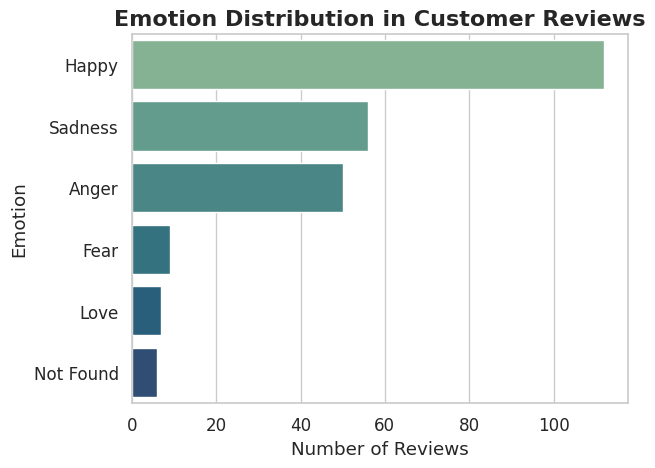

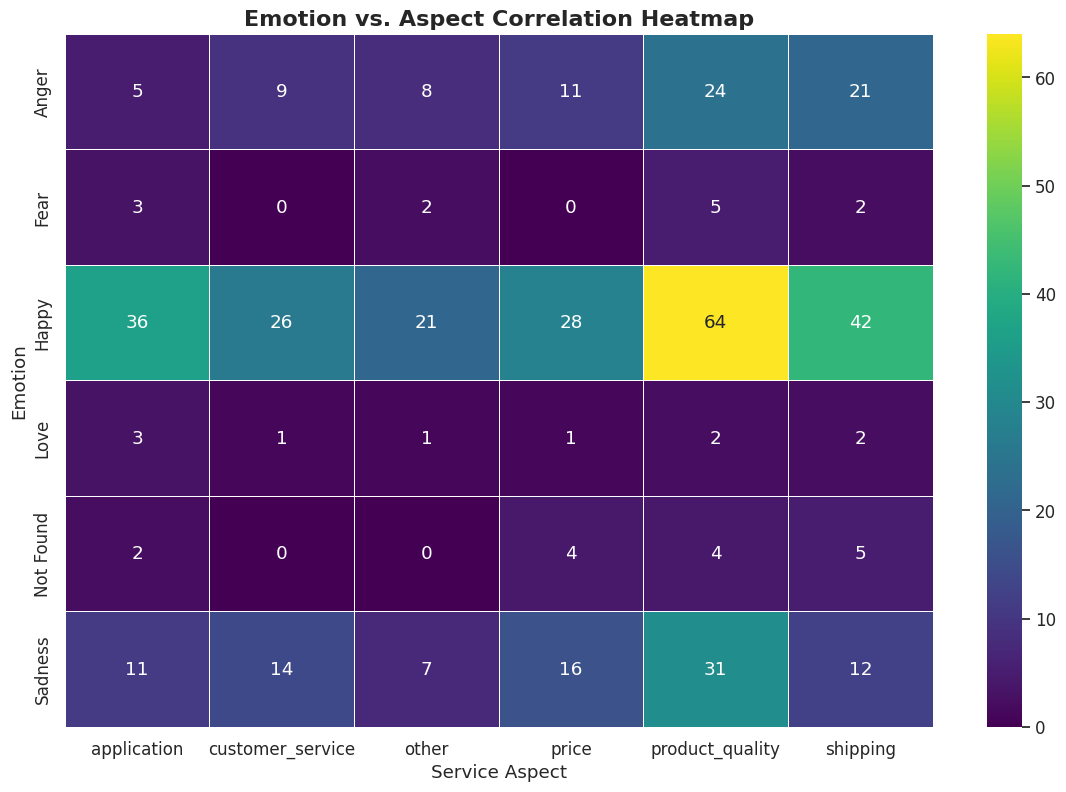

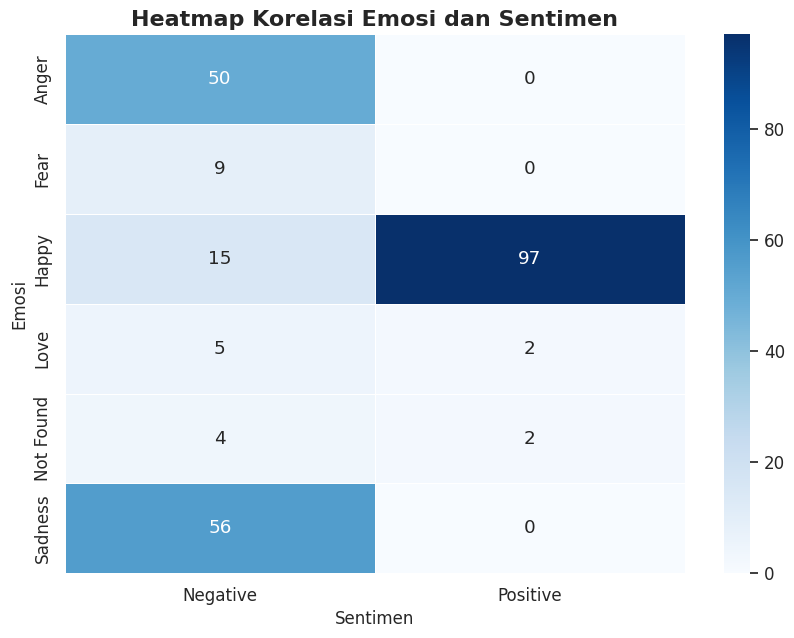


Memulai proses evaluasi kinerja model...


100%|██████████| 60/60 [00:30<00:00,  1.96it/s]


 Model Performance Classification Report (Emotion)
              precision    recall  f1-score   support

       Anger       0.38      0.62      0.48         8
        Fear       0.33      0.10      0.15        10
       Happy       0.65      1.00      0.78        20
        Love       0.00      0.00      0.00         9
     Sadness       0.69      0.69      0.69        13

    accuracy                           0.58        60
   macro avg       0.41      0.48      0.42        60
weighted avg       0.47      0.58      0.50        60



In [46]:
# Visualisasi Insight
print("\nMembuat visualisasi...")
sns.set(style="whitegrid", font_scale=1.1, font='sans-serif')

# Visualisasi Distribusi Emosi
sns.countplot(data=df_results, y='emotion', order=df_results['emotion'].value_counts().index, palette='crest')
plt.title('Emotion Distribution in Customer Reviews', fontsize=16, weight='bold')
plt.xlabel('Number of Reviews')
plt.ylabel('Emotion')
plt.show()
print("\n")
df_exploded = df_results.explode('aspects').dropna(subset=['aspects'])

# Heatmap Korelasi Emosi-Aspek
crosstab = pd.crosstab(df_exploded['emotion'], df_exploded['aspects'])
plt.figure(figsize=(14, 9))
sns.heatmap(crosstab, annot=True, fmt='d', cmap='viridis', linewidths=.5)
plt.title('Emotion vs. Aspect Correlation Heatmap', fontsize=16, weight='bold')
plt.xlabel('Service Aspect')
plt.ylabel('Emotion')
plt.show()
print("\n")

#Heatmap Korelasi Emosi vs. Sentimen
crosstab_sentiment = pd.crosstab(df_results['emotion'], df_results['sentiment'])
plt.figure(figsize=(10, 7))
sns.heatmap(crosstab_sentiment, annot=True, fmt='d', cmap='Blues', linewidths=.5)
plt.title('Heatmap Korelasi Emosi dan Sentimen', fontsize=16, weight='bold')
plt.xlabel('Sentimen', fontsize=12)
plt.ylabel('Emosi', fontsize=12)
plt.show()

# Evaluasi Kinerja Model
eval_results = []
print("\nMemulai proses evaluasi kinerja model...")
for index, row in tqdm(evaluation_samples.iterrows(), total=evaluation_samples.shape[0]):
    predicted_emotion = get_emotion(row['review'])

    true_emotion_original = row['emotion']
    true_emotion_standardized = EMOTION_MAP.get(str(true_emotion_original).lower(), str(true_emotion_original).capitalize())

    eval_results.append({'true_emotion': true_emotion_standardized, 'predicted_emotion': predicted_emotion})

df_eval = pd.DataFrame(eval_results)
df_eval_clean = df_eval[~df_eval['predicted_emotion'].str.contains('error|Not Found', na=False)]

print("\n Model Performance Classification Report (Emotion)")
print(classification_report(df_eval_clean['true_emotion'], df_eval_clean['predicted_emotion'], zero_division=0))
